# Model Training

In [1]:
import pandas as pd
import ast
import warnings
import os
warnings.filterwarnings("ignore")
import sys
sys.path.append('../')
from utils.machine_learning import DataPreprocess, ModelTraining, MetricsVisualizations

In [2]:
preprocess = DataPreprocess()
trainer = ModelTraining()

# Data

In [3]:
df = pd.read_csv("./Data/clean_air_system_previous_years.csv")

In [4]:
df.head()

,class,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,76698,2130706438,280,0,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,0,33058,0,126,0,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,0,41040,228,100,0,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,0,12,70,66,0,10,0,0,0,318,...,240,46,58,44,10,0,0,0,4,32
4,0,60874,1368,458,0,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


# Preprocessing the Data

### For the preprocess step, the data will be divided into a train and test split. Also, the maps created during the feature engineering step will be used to correctly apply the log and cubic transformations on the correct columns. The preprocessor will be saved in the **Artifacts** folder

In [5]:
X_train_all, X_test_all, y_train_all, y_test_all = preprocess.preprocess_data(df, target_name="class", test_size=0.3, )
X_train_anova, X_test_anova, y_train_anova, y_test_anova = preprocess.preprocess_data(df, target_name="class", test_size=0.3, anova=True)

# Modeling

### For the modeling phase, three models will be used: Logistic Regression, Random Forest and Gradient Boosting. Each model will be trained and tested using the cleaned original dataset and the new dataset that contains only the features selected by PCA and ANOVA
### During each training and testing, two methods will be used to solve the imbalance issue of the target. The first one is using the parameter `class_weight` on the models that have it. The second method is the utilization of `SMOTE`, an oversampling method that uses synthetic data to balance the target. `SMOTE` will only be applied to the training sets, with the test sets having the original imbalance of the data
### After the models are trained and tested, they will be evaluated in terms of the metrics `Recall`, `Precision`, `f1` and `ROC-AUC`. Recall is the main metric here, since the primary goal is to save money. The metric will measure the proportion of true positives out of the actual positives, with a high recall consisting of a low number of false negatives. Precision will measure the proportion of positive predictions that are actually correct, with fewer false positives indicating a higher precision. F1 will be the harmonic average between them, and ROC-AUC will evaluate the model's ability to discriminate the data between the two classes. Also, the top 5 most important features of each model will be plotted in relation to the decrease in `recall`
### To train the models, a repo in DagsHub will be used, along with MLflow to keep track of all the information about the models

# Models on All Features

## Using class_weight = balanced

In [6]:
model_report_all = trainer.initiate_model_trainer((X_train_all, y_train_all, X_test_all, y_test_all), "All features")

Successfully registered model 'Logistic Regression - All features'.
2024/07/12 17:52:45 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic Regression - All features, version 1
Created version '1' of model 'Logistic Regression - All features'.
Successfully registered model 'Random Forest - All features'.
2024/07/12 17:58:26 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Random Forest - All features, version 1
Created version '1' of model 'Random Forest - All features'.
Successfully registered model 'Gradient Boosting - All features'.
2024/07/12 18:16:39 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Gradient Boosting - All features, version 1
Created version '1' of model 'Gradient Boosting - All features'.


In [7]:
metrics_all = MetricsVisualizations(model_report_all)

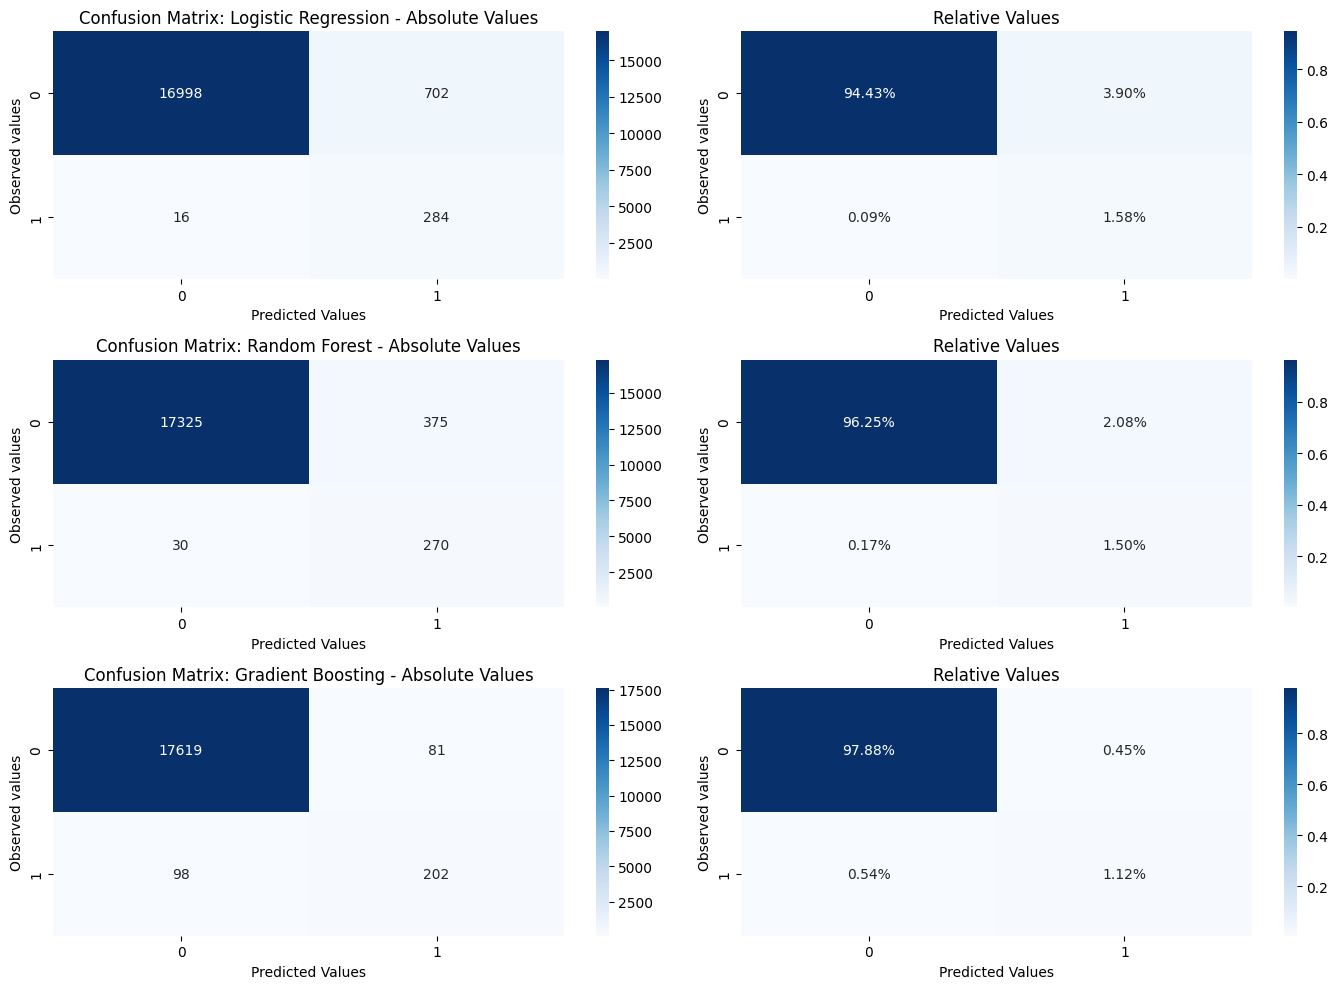

In [8]:
metrics_all.visualize_confusion_matrix(y_test_all, 3, 2)

### Observations:
- The logistic regression model had a very high number of false positives, indicating that the model has very little `precision`. Despite having a high `recall`, the amount of false positives makes this model far from ideal in an industry environment
- The random forest model had a way lower number of false positives, but double the amount of false negatives
- The gradient boosting model was the worst performer, with an extremely high amount of false negatives
- Given that the cost for each false negative of a model is $500 and the cost of a false positive is $10, the most cost-effective model here is the logistic regression, with the random forest being a behind in the cost measurement but having to stop a lot of fewer trucks with false alarms

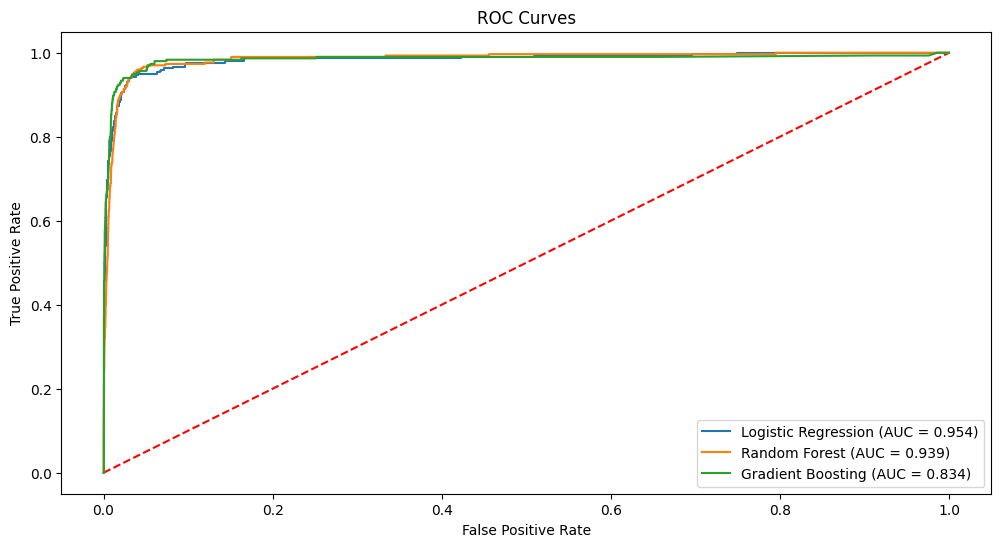

In [9]:
metrics_all.visualize_roc_curves()

### Observations:
- Logistic regression and random forest have the highest ROC-AUC scores, indicating that both of them are excellent at discriminating the data between both classes
- The gradient boosting model shows a decent score, but it's very mediocre when compared to the other two models

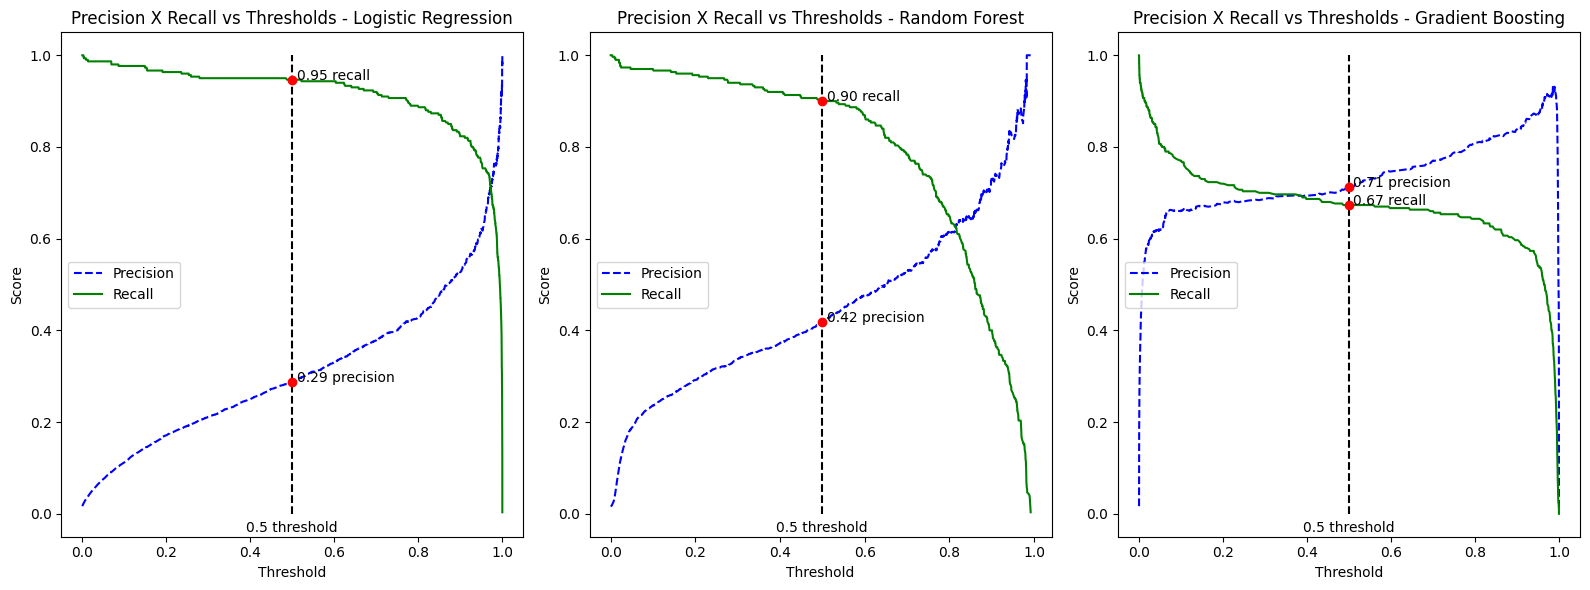

In [10]:
metrics_all.plot_precision_recall_threshold(y_test_all, X_test_all, 1, 3)

### Observations:
- Logistic regression and random forest shows that trying to perfect balance the `recall` and `precision` would result in a very big reduction of the `recall` metric. This means that the models would have a lot more false negatives, increasing the amount of money spent
- Gradient boosting shows that it is possible to balance these metrics, but `recall` would still be very low

## Feature Importance

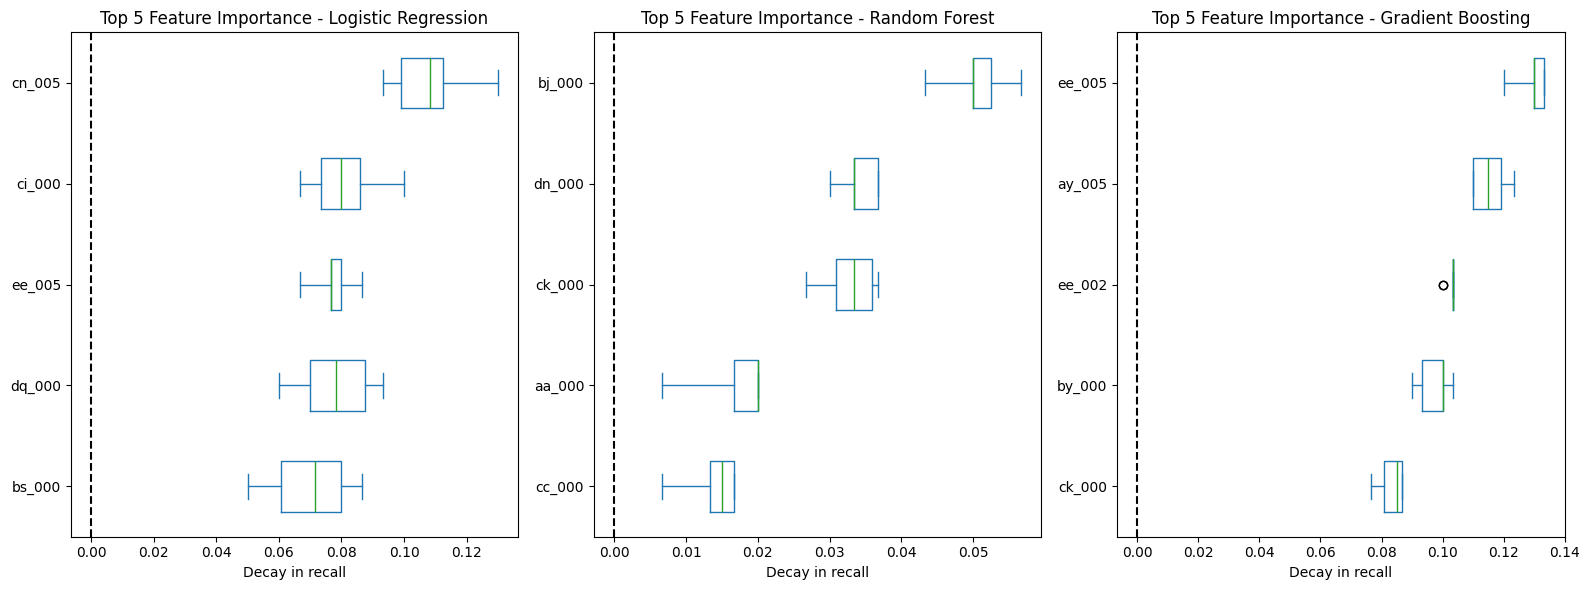

In [132]:
metrics_all.plot_feature_importance(y_test_all, X_test_all, "recall", 1, 3)

### Observations:
- For the logistic regression model, `cn_005` is by far the most important feature, with the other 4 being basically tied. This means that when the values of `cn_005` are permutated, it leads to a decay in recall of up to 0.12, making the model worse
- For the random forest model, no feature had a big permutation score, with `bj_000` being the most important one
- For the gradient boosting model, `ee_005` is the most important feature. This feature is also the third most important one in the logistic regression model

## Using SMOTE

In [12]:
model_report_all_smote = trainer.initiate_model_trainer((X_train_all, y_train_all, X_test_all, y_test_all), "All features", use_smote=True)

Registered model 'Logistic Regression - All features' already exists. Creating a new version of this model...
2024/07/12 18:20:02 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic Regression - All features, version 2
Created version '2' of model 'Logistic Regression - All features'.
Registered model 'Random Forest - All features' already exists. Creating a new version of this model...
2024/07/12 18:40:37 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Random Forest - All features, version 2
Created version '2' of model 'Random Forest - All features'.
Registered model 'Gradient Boosting - All features' already exists. Creating a new version of this model...
2024/07/12 19:37:20 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Gradient Boosting - All featu

In [13]:
metrics_all_smote = MetricsVisualizations(model_report_all_smote)

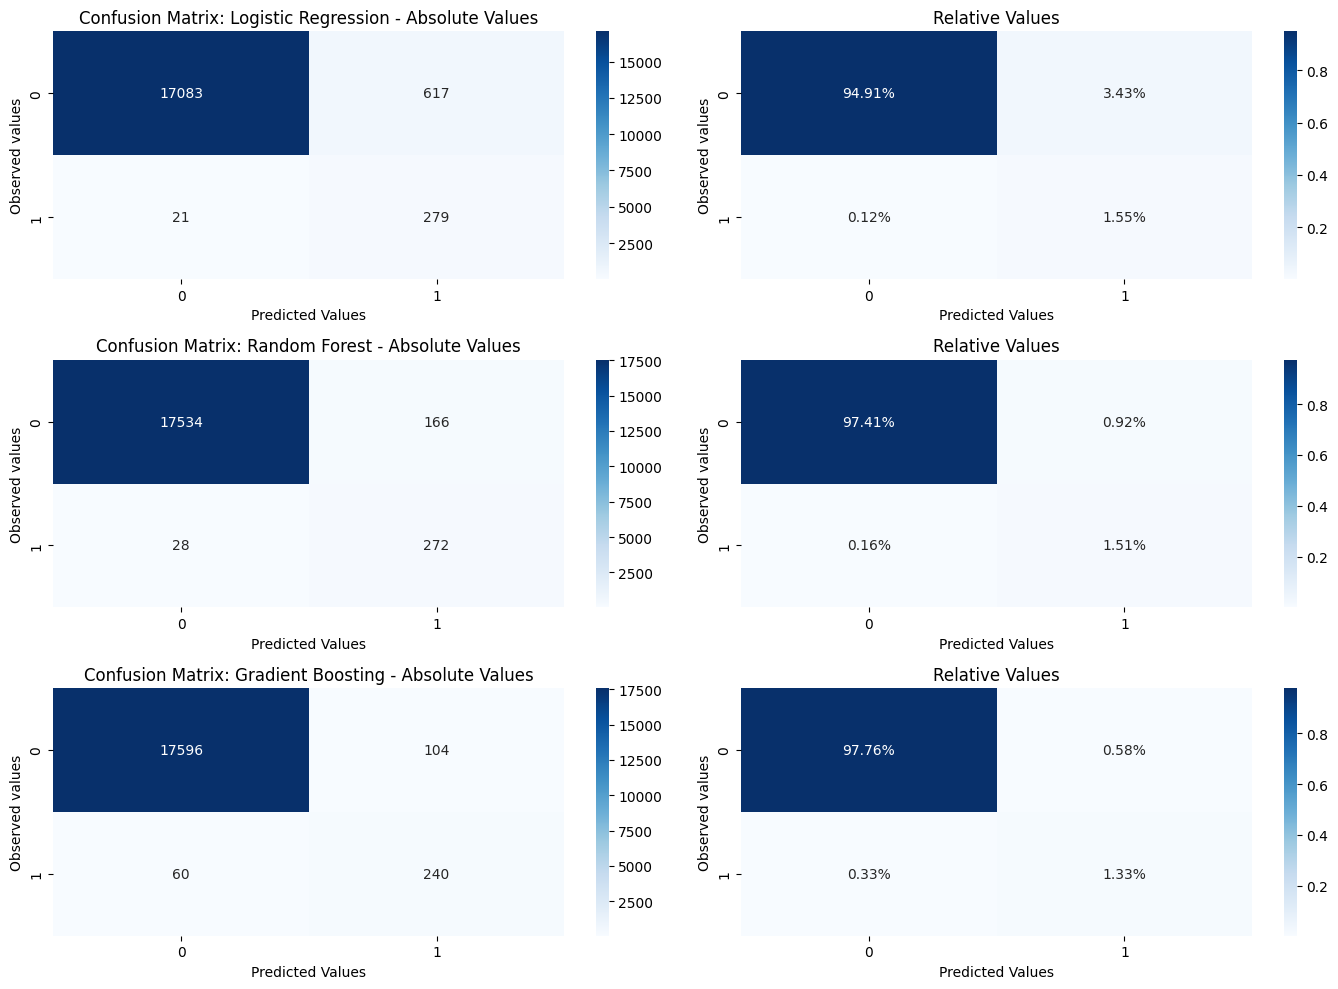

In [14]:
metrics_all_smote.visualize_confusion_matrix(y_test_all, 3, 2)

### Observations:
- When using `SMOTE` to balance the data, the logistic regression model saw a small increase in false negatives
- For the random forest model, the `SMOTE` utilization improved the model in terms of false positives, with a total of 166, compared to more than 300 in the previous version. Another positive point is that despite increasing the `precision`, `recall` also increased
- The gradient boosting model showed an increase in `recall`, but it's still too low
- If these results, this random forest is now very close to be the best model in terms of cost of error and is by far the best in terms of the amount of trucks being stopped by mistake

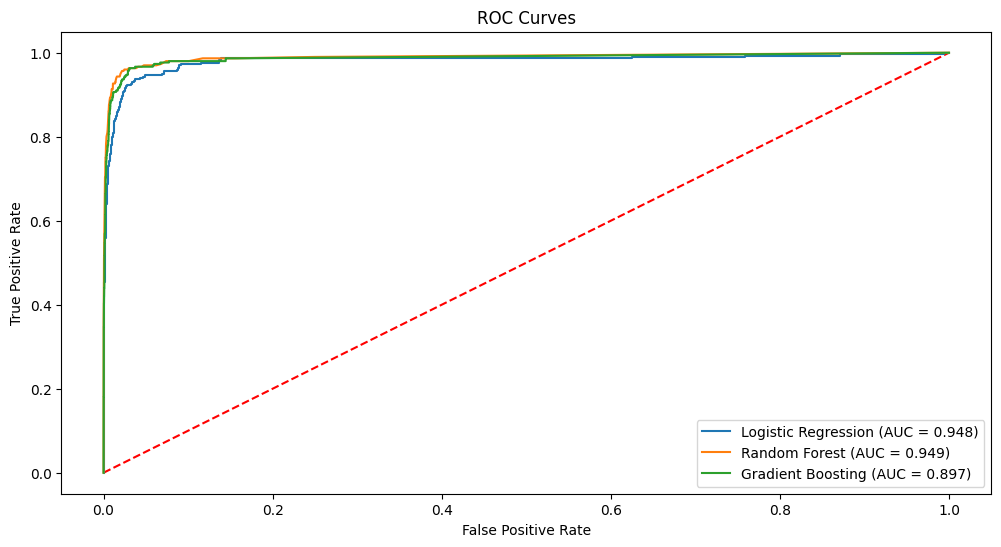

In [15]:
metrics_all_smote.visualize_roc_curves()

### Observations:
- Now all models have a similiar ROC-AUC score, indicating that all of them are excellent at discriminating the data between both classes

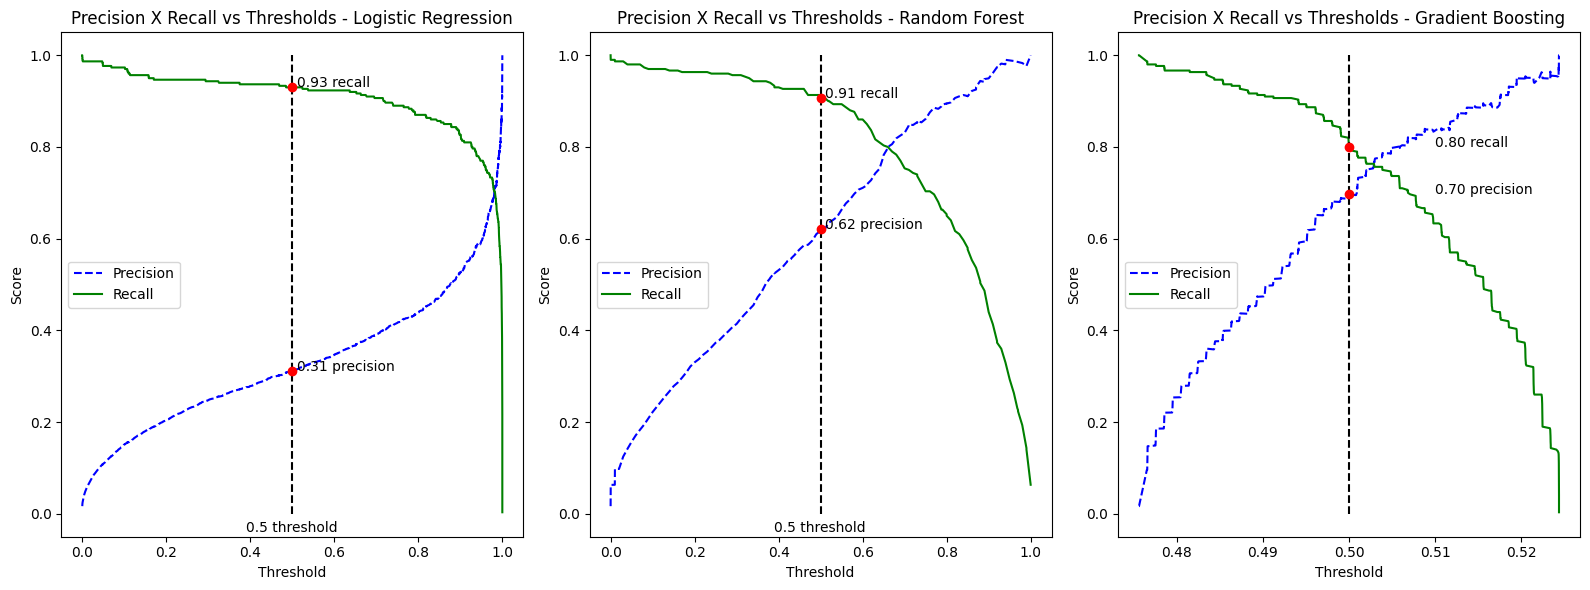

In [16]:
metrics_all_smote.plot_precision_recall_threshold(y_test_all, X_test_all, 1, 3)

### Observations:
- No change to logistic regression
- Random forest had a big increase in `precision` and `recall`, with margin to change its threshold to increase recall even more
- Gradient boosting shows way better lines for each metric

## Feature Importance

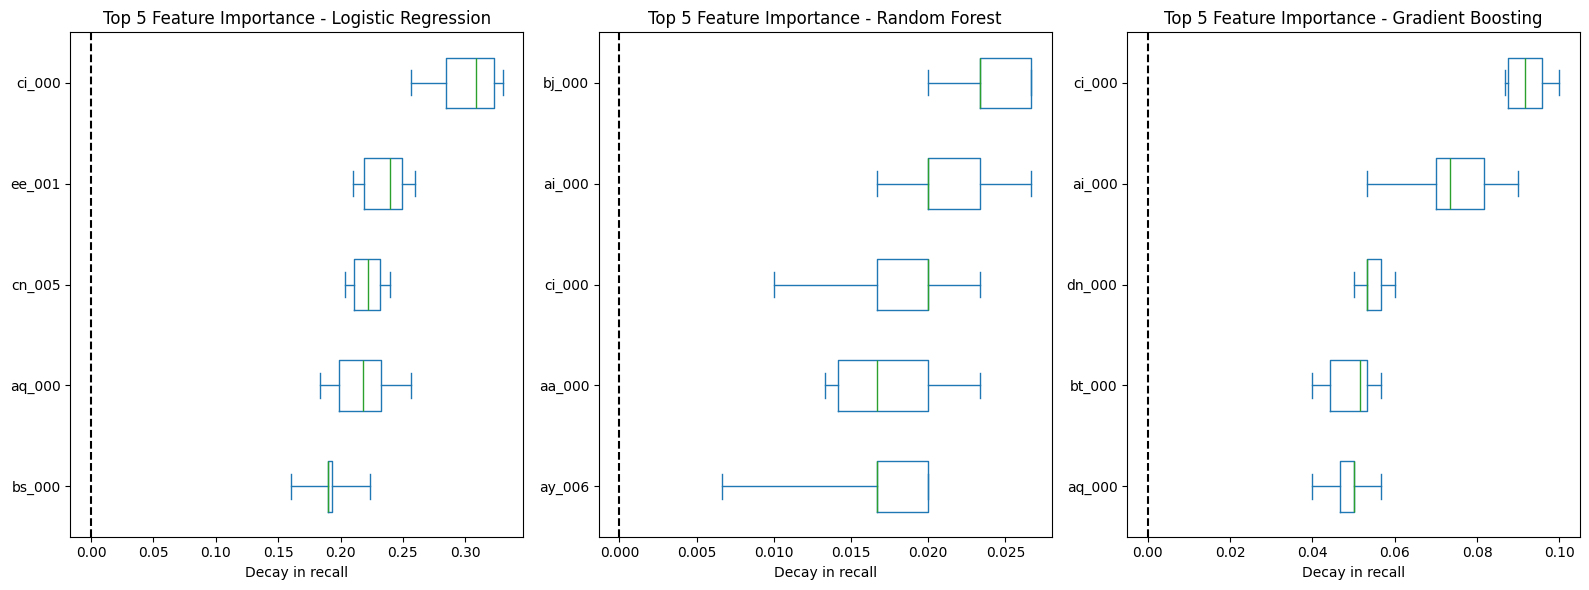

In [134]:
metrics_all_smote.plot_feature_importance(y_test_all, X_test_all, "recall", 1, 3)

### Observations:
- For the logistic regression model, `cn_005` is now the third most important feature, with `ci_000` in the top spot
- For the random forest model, `bj_000` is still in the top spot, but it's almost tied with the other features
- Gradient boosting has the same top feature as the logistic regression model

# Models on selected features by PCA and ANOVA

## Using class_weight = balanced

In [18]:
model_report_anova = trainer.initiate_model_trainer((X_train_anova, y_train_anova, X_test_anova, y_test_anova), "Anova features")

Successfully registered model 'Logistic Regression - Anova features'.
2024/07/12 19:39:57 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic Regression - Anova features, version 1
Created version '1' of model 'Logistic Regression - Anova features'.
Successfully registered model 'Random Forest - Anova features'.
2024/07/12 19:45:22 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Random Forest - Anova features, version 1
Created version '1' of model 'Random Forest - Anova features'.
Successfully registered model 'Gradient Boosting - Anova features'.
2024/07/12 20:00:16 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Gradient Boosting - Anova features, version 1
Created version '1' of model 'Gradient Boosting - Anova features'.


In [19]:
metrics_anova = MetricsVisualizations(model_report_anova)

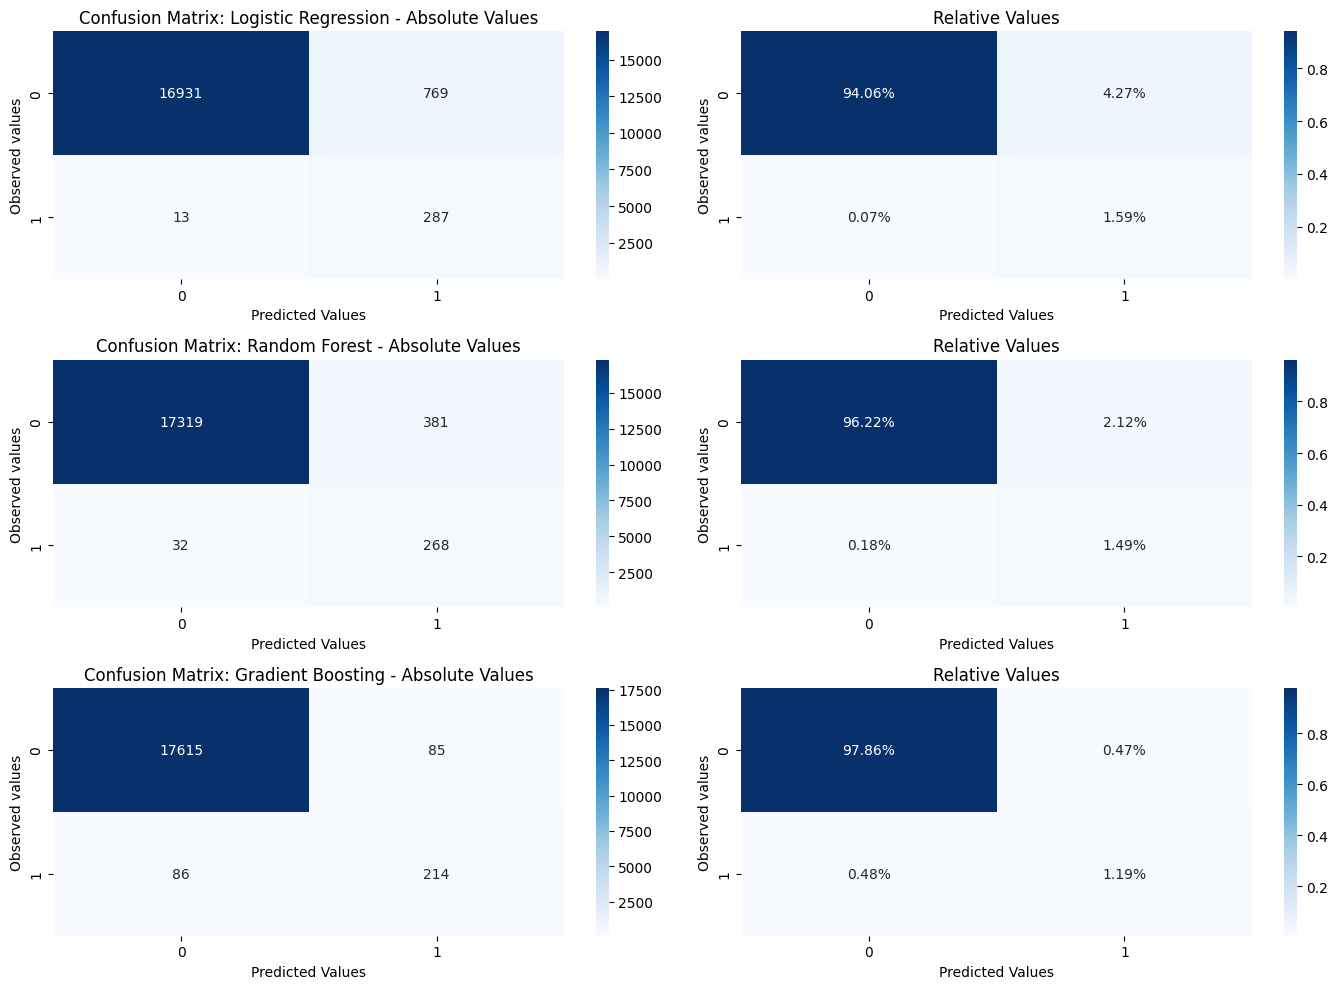

In [20]:
metrics_anova.visualize_confusion_matrix(y_test_anova, 3, 2)

### Observations:
- Using only the columns selected by the PCA and ANOVA methods, we can see that there's not much change from the results of the models using all features. This is a good sign since the goal was to select the minimal amount of features without losing a lot of data variance

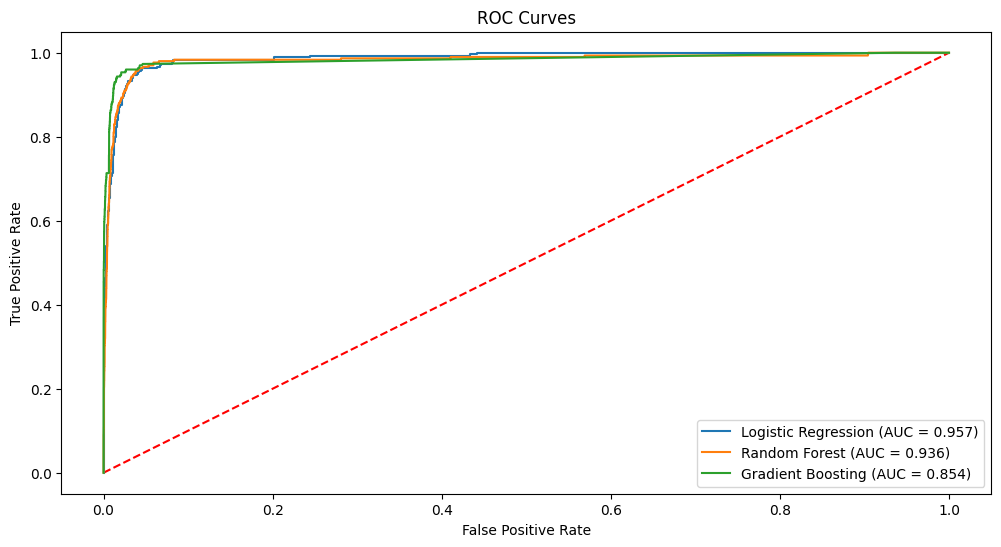

In [21]:
metrics_anova.visualize_roc_curves()

### Observations:
- Again the results show no major difference from the same models with all columns. Despite having a good score, gradient boosting still feels mediocre compared to the other models scores

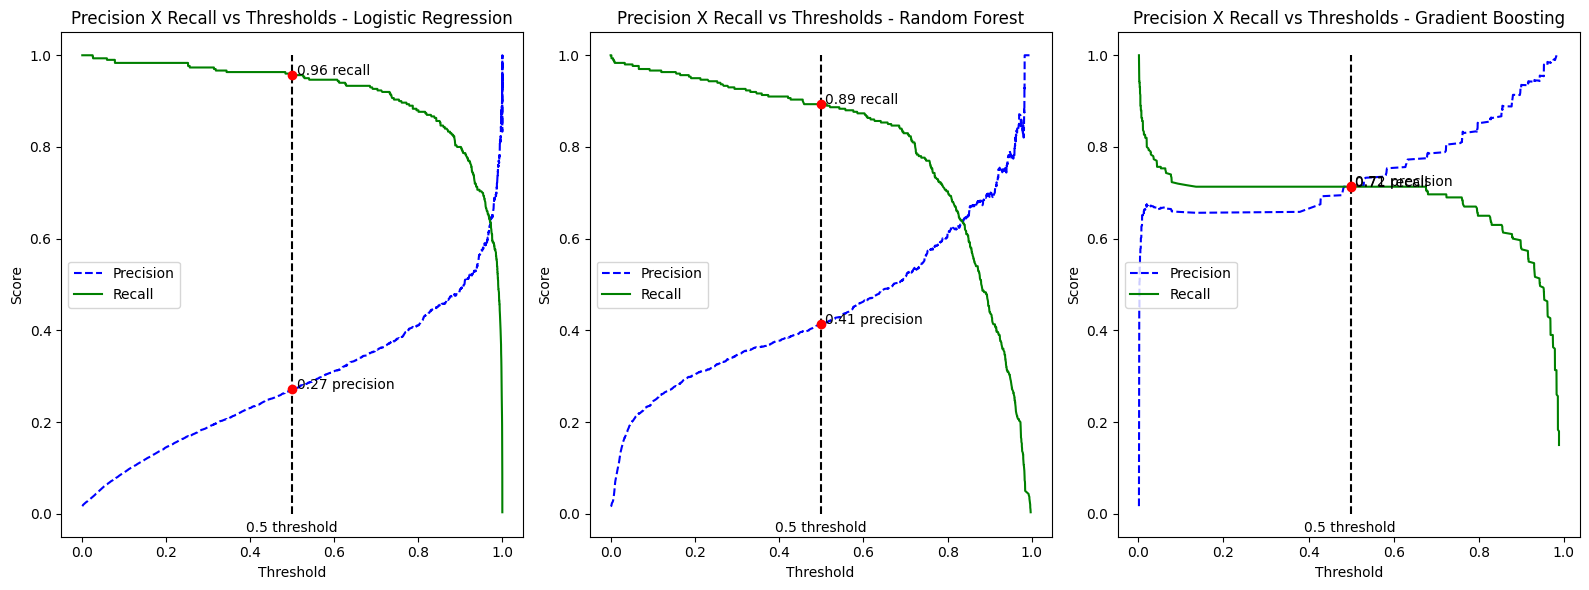

In [22]:
metrics_anova.plot_precision_recall_threshold(y_test_anova, X_test_anova, 1, 3)

### Observations:
- Logistic regression has a higher `recall`
- Other models behave the same way as before

## Feature Importance

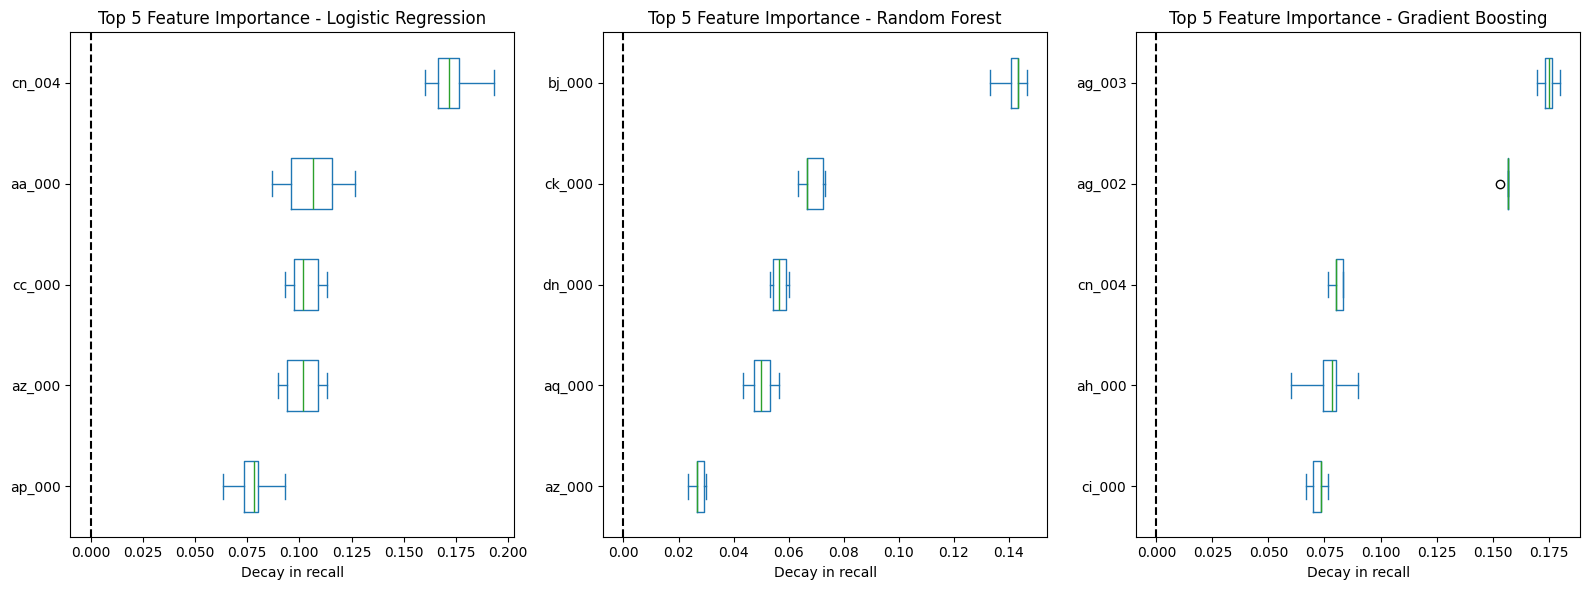

In [137]:
metrics_anova.plot_feature_importance(y_test_anova, X_test_anova, "recall", 1, 3)

### Observations:
- When using the columns selected with PCA and ANOVA, the logistic regression and gradient boosting models show different features in the top 5
- Random forest still has `bj_000` as the most important one

## Using SMOTE

In [24]:
model_report_anova_smote = trainer.initiate_model_trainer((X_train_anova, y_train_anova, X_test_anova, y_test_anova), "Anova features", use_smote=True)

Registered model 'Logistic Regression - Anova features' already exists. Creating a new version of this model...
2024/07/12 20:01:33 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic Regression - Anova features, version 2
Created version '2' of model 'Logistic Regression - Anova features'.
Registered model 'Random Forest - Anova features' already exists. Creating a new version of this model...
2024/07/12 20:19:41 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Random Forest - Anova features, version 2
Created version '2' of model 'Random Forest - Anova features'.
Registered model 'Gradient Boosting - Anova features' already exists. Creating a new version of this model...
2024/07/12 21:10:11 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Gradient Boosti

In [25]:
metrics_anova_smote = MetricsVisualizations(model_report_anova_smote)

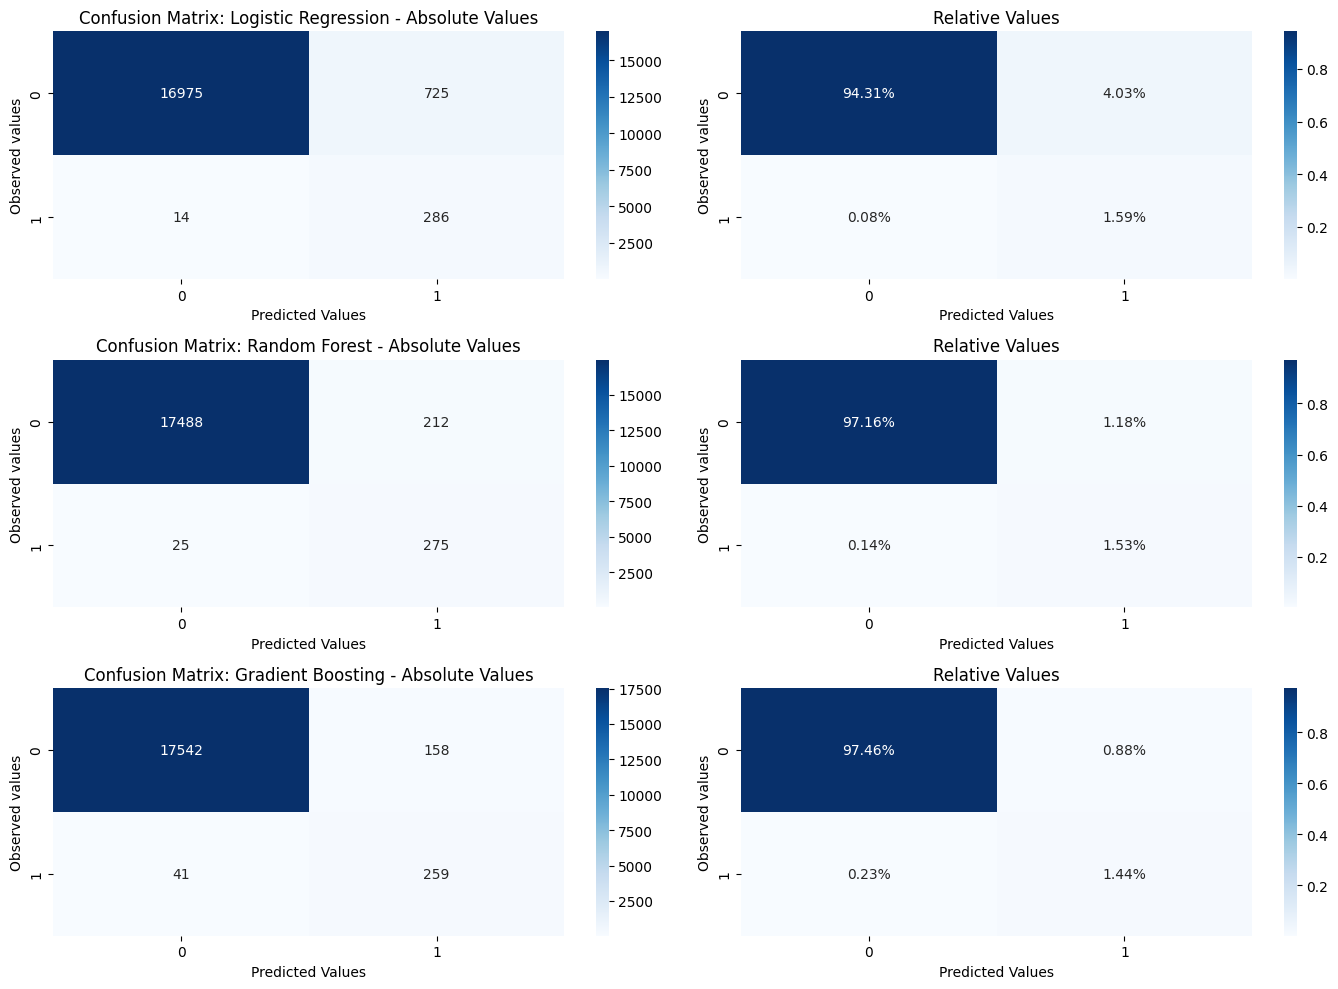

In [26]:
metrics_anova_smote.visualize_confusion_matrix(y_test_anova, 3, 2)

### Observations:
- Similar to all data, using SMOTE seems to be very good for the random forest model, showing a low number of false positives and a moderate number of false negatives

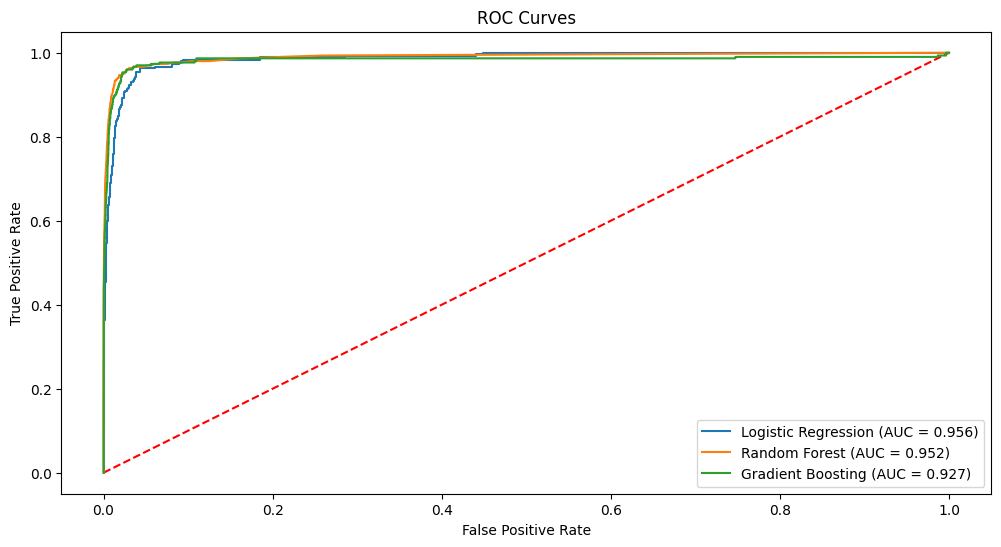

In [27]:
metrics_anova_smote.visualize_roc_curves()

### Observations:
- All models have a very good score

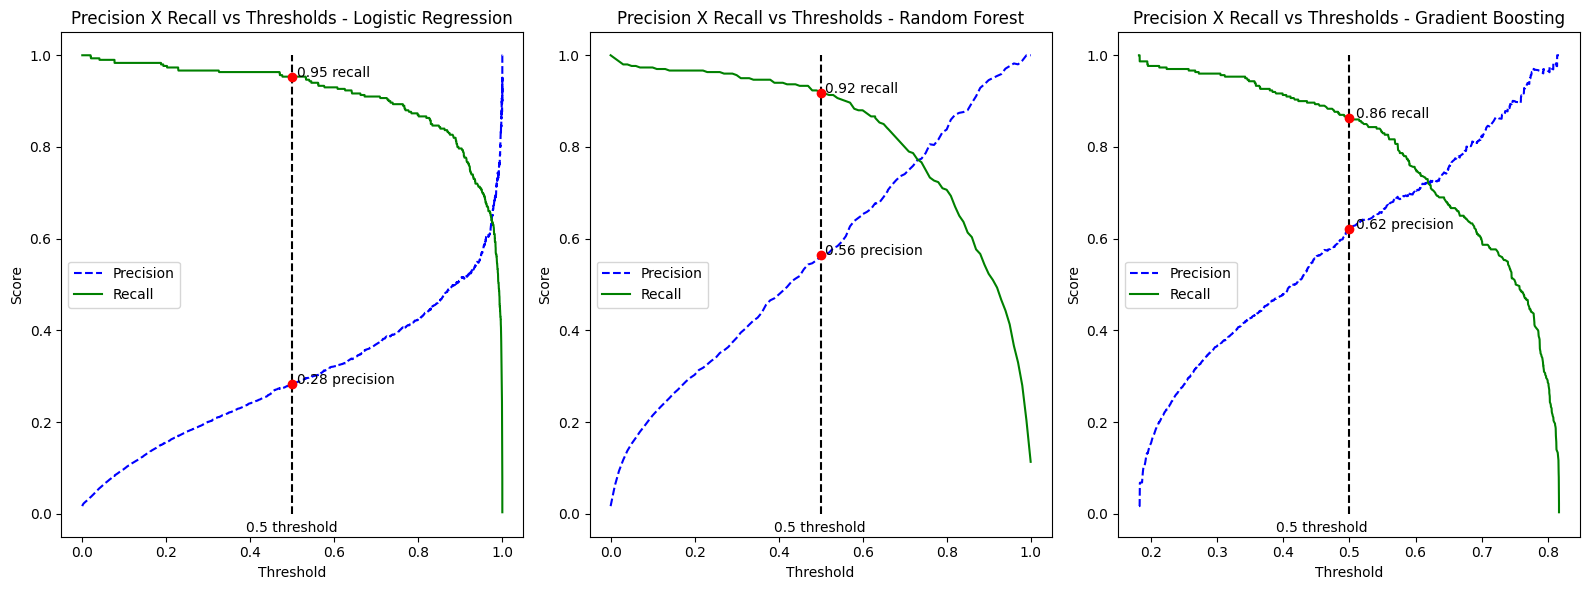

In [28]:
metrics_anova_smote.plot_precision_recall_threshold(y_test_anova, X_test_anova, 1, 3)

### Observations:
- No change for logistic regression
- Both random forest and gradient boosting can have their treshold altered to increase their recall, with a moderate decrease in precision

## Feature Importance

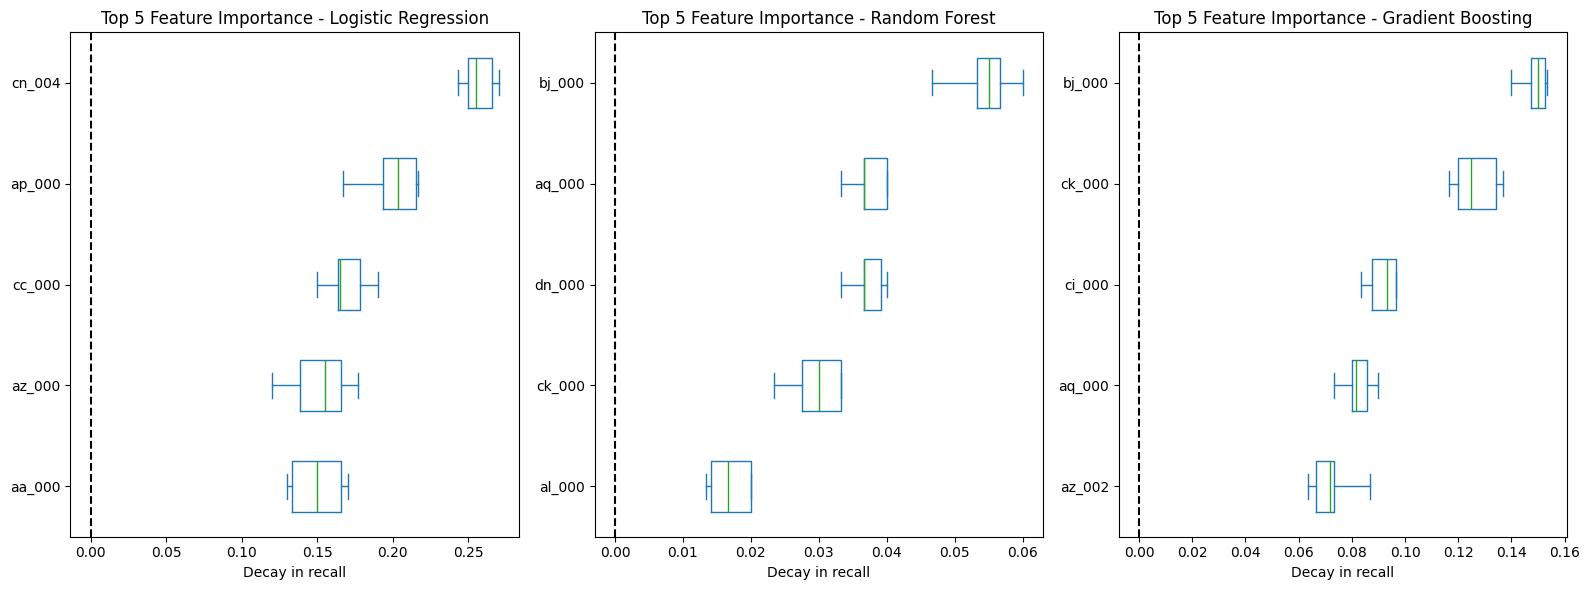

In [139]:
metrics_anova_smote.plot_feature_importance(y_test_anova, X_test_anova, "recall", 1, 3)

### Observations:
- The logistic regression model has the same top 5 features when using features from PCA and ANOVA, with and without SMOTE
- Random forest has `bj_000` as the most important feature in all cases
- Gradient boosting now has `bj_000` as the most important feature

# Conclusion
### Based on the analysis of every model trained and tested using two methods to balance the data, it is clear that the gradient boosting model is not the right choice. Despite having a constant behavior on all tests, the number of false negatives was always too high, which is very bad for what the business requires
### The Logistic regression model had good performances, but suffered from a high number of false positives
### The best model was the `random forest` with the features from PCA and ANOVA with `class_balance` as balanced. In a first look, the model seems bad, with a moderate number of false positives and negatives. But when we do a threshold analysis, it's possible to see that when lowering the treshold to around 0.2, the `recall` goes up by a lot, with a samll penalty to `precision`. Another point is the high scores on the `ROC-AUC` curve, staying above 0.9 in every test, proving that this model is excellent at discriminating the data between both classes

# Saving, loading and using the best model

In [183]:
trainer.save_model("Random Forest - Anova features", 1, "../artifacts", "model")

In [185]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

In [186]:
model_path = "../artifacts/model.pkl"
with open(model_path, "rb") as f:
    model = pickle.load(f)

In [187]:
df_present = pd.read_csv("./Data/air_system_present_year.csv")

In [188]:
X_test, y_test= preprocess.preprocess_data(df_present.copy(), target_name="class", anova=True, new_data=True)

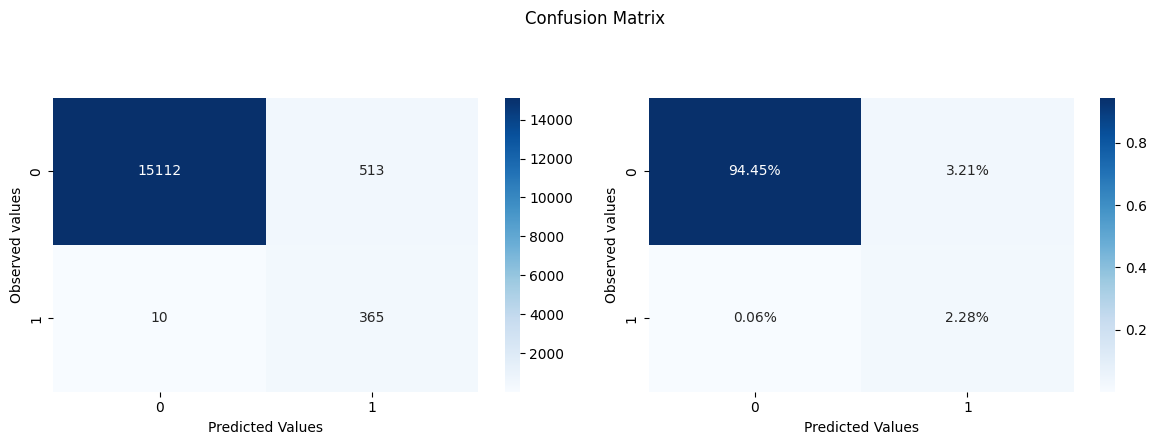

In [190]:
y_pred = model.predict_proba(X_test)[:,1]
# Changing the threshold to 0.2
y_pred_adjusted = (y_pred >= 0.2).astype(int)
matrix = confusion_matrix(y_test, y_pred_adjusted)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
fig.suptitle('Confusion Matrix', y=1.1)
# Plot the first heatmap
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", ax=ax1)
ax1.set_xlabel("Predicted Values")
ax1.set_ylabel("Observed values")
# Plot the second heatmap
sns.heatmap(matrix / np.sum(matrix), annot=True, fmt=".2%", cmap="Blues", ax=ax2)
ax2.set_xlabel("Predicted Values")
ax2.set_ylabel("Observed values")
fig.tight_layout()
plt.show()

## The cost of mistakes in the chosen model is **$10.130**, with only 10 trucks that had failures not being sent to maintenance. To calculate this amount, I took the 10 false negative trucks and multiplied by the cost of not sending a truck with a failure to maintenance, which is **$500**, and added with the multiplication of the number of trucks sent to maintenance without a failure by the price for this mistake, which is **$10**.
## To get the total cost overall of the model, just add the price of **$25** for all 365 trucks correctly sent to maintenance when there was indeed a failure. The total cost of the model is only **$19.255**. That is **$4.745** or **19.7%** of money saved in comparison to the costs with maintenance during the year 2016, which was the year with the lowest cost. Comparing with 2020, the year of the biggest maintenance cost, the model saves **$17.745** or **48%**